In [81]:
from numpy import random, cos, sin, sqrt, pi
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd

def disturb(x, n, sigma):
    eps = random.normal(loc=0, scale=sigma, size=n)
    return x + eps

def set_options(ax):
    ax.grid(False)
    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    
def rand_sphere(n, r, sigma):
    """n points distributed evenly on the surface of a unit sphere""" 
    z = r * (2 * random.rand(n) - 1)   # uniform in -1, 1
    t = 2 * pi * random.rand(n)   # uniform in 0, 2*pi
    x = sqrt(r**2 - z**2) * cos(t)
    y = sqrt(r**2 - z**2) * sin(t)
    x = disturb(x, n, sigma); y = disturb(y, n, sigma); z = disturb(z, n, sigma)
    return x, y, z

def synthetic_noise(N, r1, r2, sigma, show=True):    
    p1 = rand_sphere(int(N/2), r1, sigma)
    p2 = rand_sphere(int(N/2), r2, sigma)
    data1 = pd.DataFrame({'V1': p1[0], 'V2': p1[1], 'V3': p1[2], 'Y': np.ones(p1[0].shape).astype(int)})
    data2 = pd.DataFrame({'V1': p2[0], 'V2': p2[1], 'V3': p2[2], 'Y': (2*np.ones(p2[0].shape)).astype(int)})
    data = pd.concat((data1, data2), axis=0)
    data = data.sample(frac=1).reset_index(drop=True)
    if show:
        x, y, z = p1
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, color='blue')
        x, y, z = p2
        ax.scatter(x, y, z, color='red')
        set_options(ax)
        plt.show()
    return data

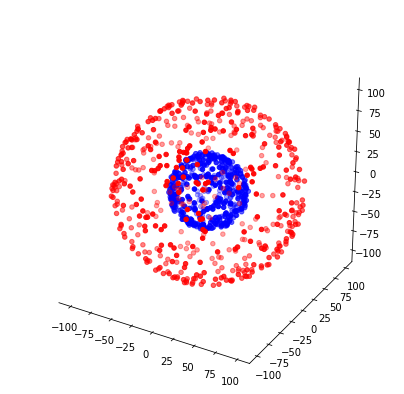

In [82]:
data = synthetic_noise(1000, 40, 100, 1)

,V1,V2,V3,Y
0,6.162795,-20.920547,31.872776,1
1,-31.100150,-91.632415,-29.050922,2
2,36.320010,13.376525,12.489690,1
3,72.576051,-6.977857,-66.524882,2
4,-13.690299,-2.551777,-36.187672,1
